In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA, PCA
from path import Path
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from lib.autoencoder import AutoEncoder
import tensorflow as tf
import lib.noisy as noisy

In [2]:
def recostruction_error(X, X_cap):
    return (np.power(np.sum(np.power((X-X_cap),2), axis = 1),1/2)).values

In [3]:
plt.style.use('ggplot')

In [4]:
PROJ_DIR = Path().getcwd().parent
DATA_DIR = PROJ_DIR / "data"
df = pd.read_csv(DATA_DIR / 'pm2_5.csv' )

In [5]:
df.tail()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0
43823,43824,2014,12,31,23,12.0,-21,-3.0,1034.0,NW,249.85,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
No       43824 non-null int64
year     43824 non-null int64
month    43824 non-null int64
day      43824 non-null int64
hour     43824 non-null int64
pm2.5    41757 non-null float64
DEWP     43824 non-null int64
TEMP     43824 non-null float64
PRES     43824 non-null float64
cbwd     43824 non-null object
Iws      43824 non-null float64
Is       43824 non-null int64
Ir       43824 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [7]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f10067828d0>,
      dtype=object)

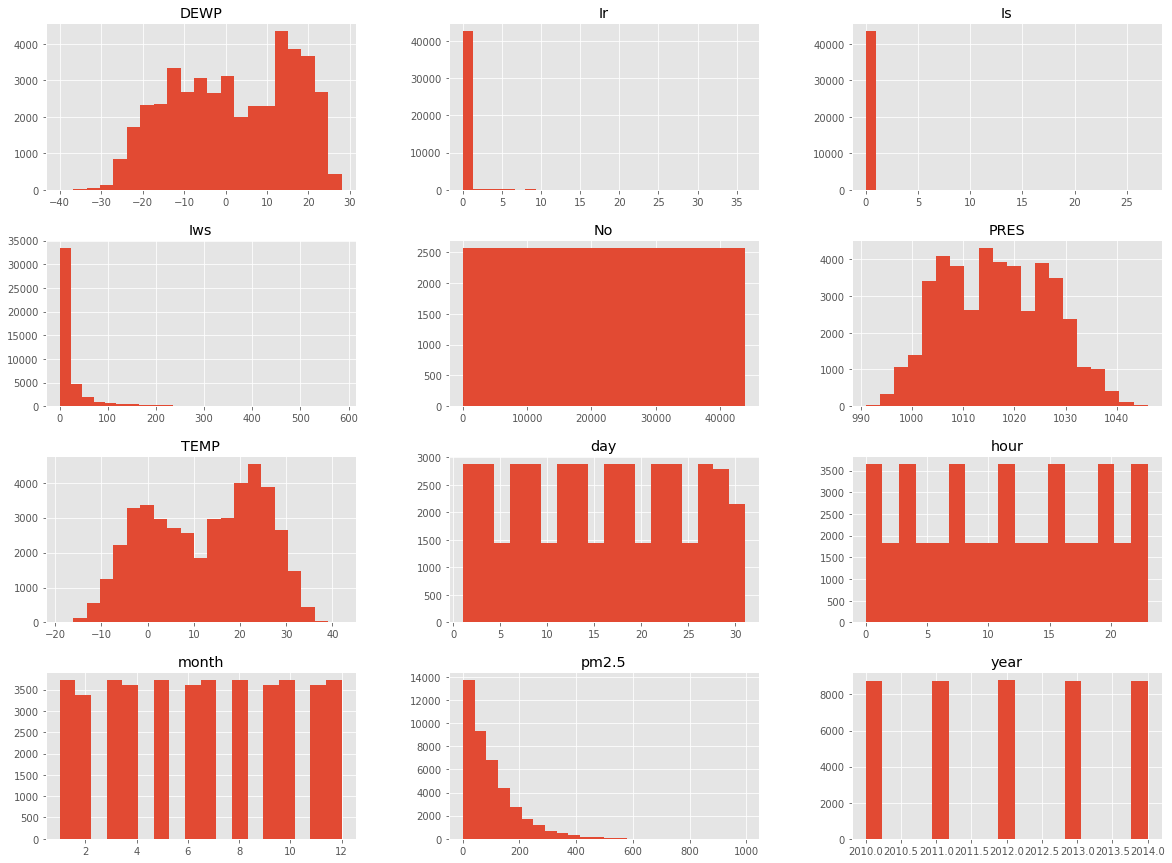

In [8]:
df.hist(bins='doane',figsize=(20,15))

In [9]:
df["Ir"].value_counts()

0     42016
1       529
2       316
3       214
4       136
5       113
6        88
7        74
8        55
9        45
10       37
11       32
12       26
13       21
14       18
15       12
17       10
18       10
16        9
19        9
20        8
22        8
21        7
23        7
25        3
24        3
30        2
26        2
27        2
28        2
29        2
32        2
31        2
36        1
35        1
34        1
33        1
Name: Ir, dtype: int64

In [10]:
df["Is"].value_counts()

0     43456
1        66
2        46
3        37
4        31
5        27
6        25
7        21
8        20
9        15
10       14
11       10
12        7
13        7
14        6
15        5
16        5
17        5
18        4
19        4
20        3
21        2
22        2
23        2
26        1
24        1
25        1
27        1
Name: Is, dtype: int64

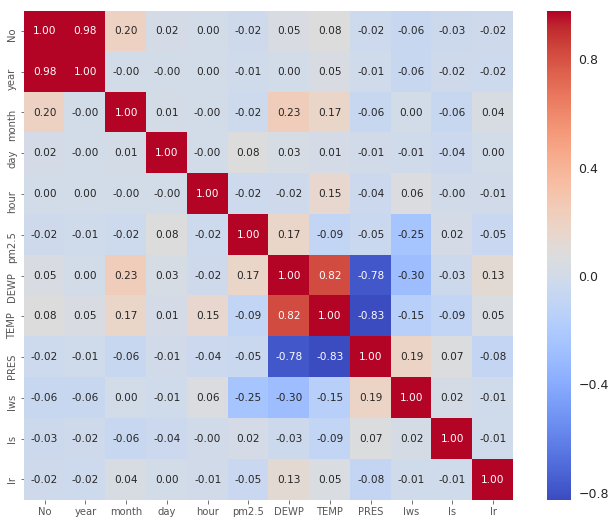

In [11]:
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)
sns.heatmap(data=df.corr(), cmap='coolwarm',vmax=.98, cbar=True, annot=True, fmt='.2f', annot_kws={'size': 10.5}, square=True)

In [12]:
#sns.pairplot(data=df, size=4)

In [13]:
df = df.dropna()

In [14]:
Date = pd.DataFrame(data= df.loc[:,'year':'hour'],columns=["year", "month", "day", "hour"])

In [15]:
Date = pd.to_datetime(Date)

In [16]:
cbwd_col = df['cbwd']
df = df.drop(columns=["year", "month", "day", "hour", "cbwd","No"])

In [17]:
SC = StandardScaler()
df = pd.DataFrame(data = SC.fit_transform(df), columns= df.columns)

In [18]:
df['Date'] = Date.values

In [19]:
X_train = df[:int(df.shape[0]*0.7)]
X_test = df[int(df.shape[0]*0.7):]
X_train = X_train.set_index('Date')
X_test = X_test.set_index('Date')

In [20]:
X_test

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
Date,,,,,,,
2013-07-21 23:00:00,-0.484667,1.333692,0.952638,-1.110895,-0.030771,-0.071057,-0.137408
2013-07-22 00:00:00,-0.408620,1.333692,0.952638,-1.110895,-0.012833,-0.071057,-0.137408
2013-07-22 01:00:00,-0.278255,1.264409,1.034773,-1.110895,0.050250,-0.071057,-0.137408
2013-07-22 02:00:00,-0.158754,1.264409,0.870503,-1.207977,0.068188,-0.071057,-0.137408
2013-07-22 03:00:00,-0.071844,1.264409,0.788368,-1.110895,0.086125,-0.071057,-0.137408
2013-07-22 04:00:00,-0.071844,1.333692,0.870503,-1.110895,0.122201,-0.071057,-0.137408
2013-07-22 05:00:00,0.058521,1.264409,0.788368,-1.110895,-0.463083,-0.071057,-0.137408
2013-07-22 06:00:00,0.210613,1.333692,0.870503,-1.110895,-0.444944,-0.071057,-0.137408
2013-07-22 07:00:00,0.275796,1.402976,1.034773,-1.207977,-0.408868,-0.071057,-0.137408


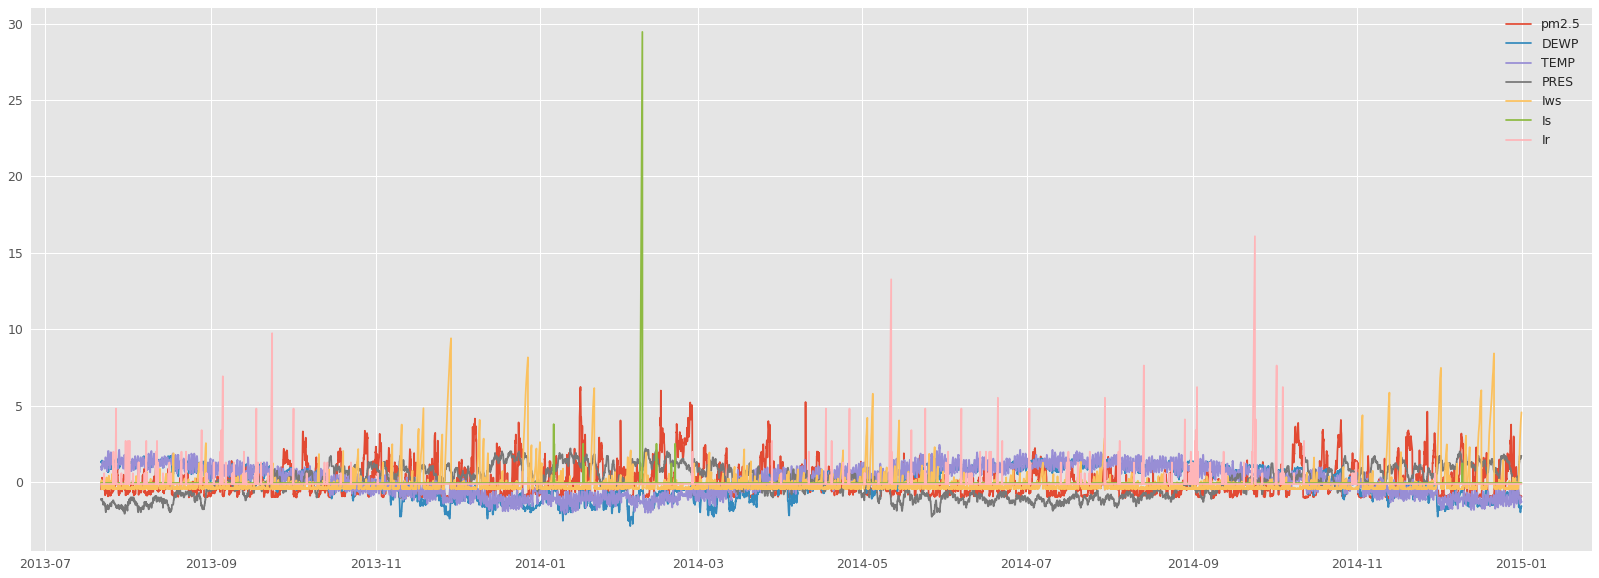

In [21]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.plot(X_test)
    plt.legend(X_test)

In [22]:
PCA = PCA(n_components=4)
PCA.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [23]:
print("variance ratio: ", PCA.explained_variance_ratio_)
print("sum of variance percentage: ", round(sum(PCA.explained_variance_ratio_)*100))

variance ratio:  [0.37478967 0.17284042 0.15862391 0.15057198]
sum of variance percentage:  86.0


In [24]:
X_test_pca = PCA.transform(X_test)
X_projected_test = PCA.inverse_transform(X_test_pca)
error_e_test = recostruction_error(X_test, X_projected_test)

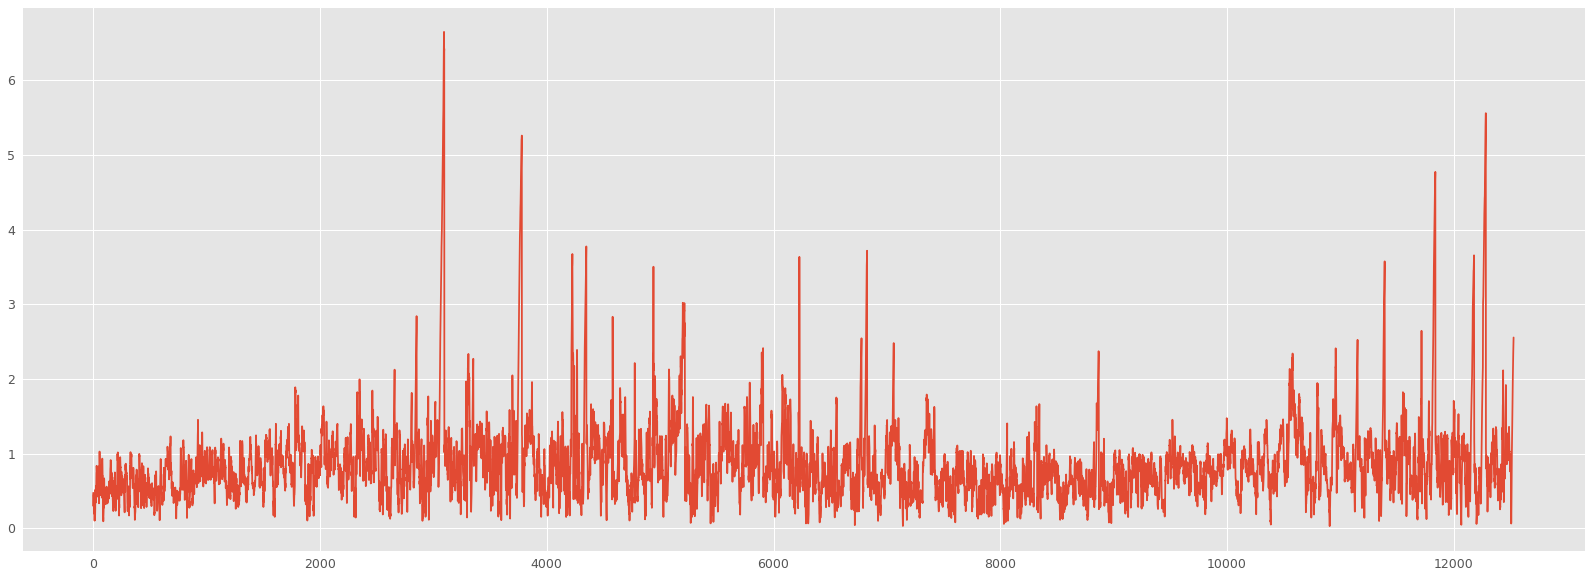

In [25]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.plot(error_e_test)

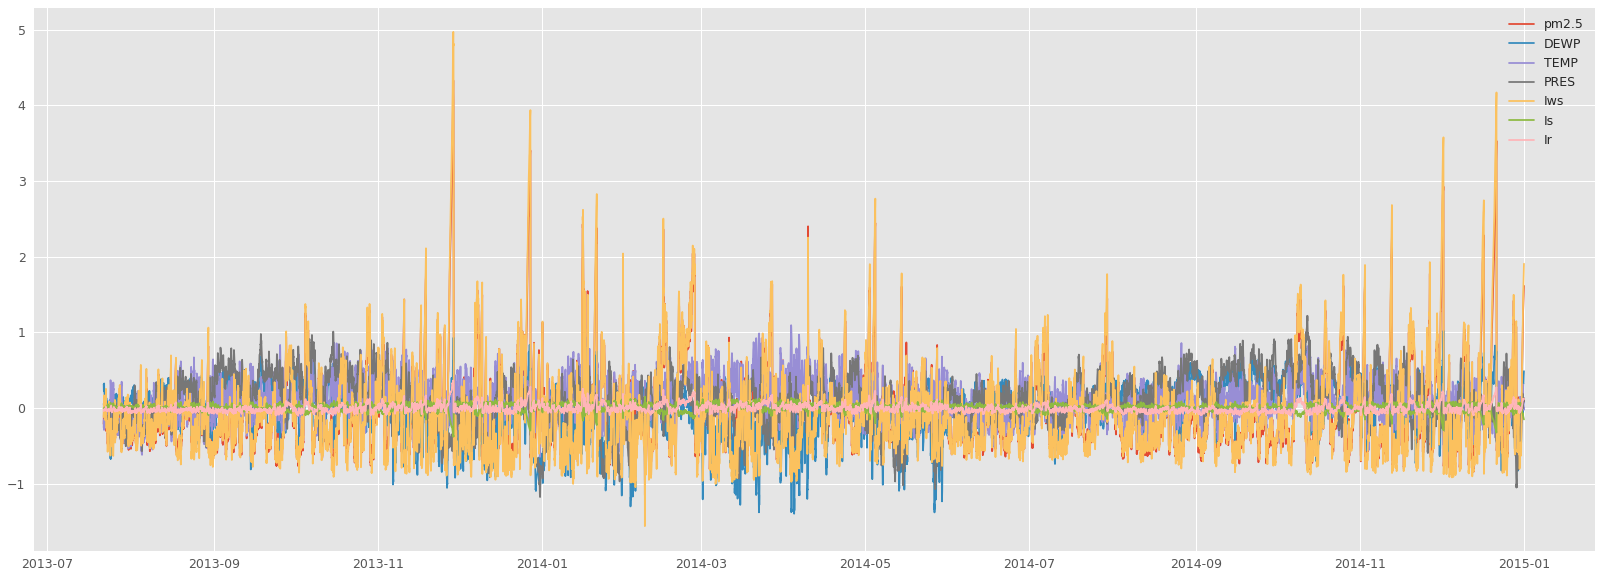

In [26]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.plot(X_test-X_projected_test)
    plt.legend(X_test-X_projected_test)

In [27]:
#KPCA = KernelPCA(n_components=3, kernel='rbf', fit_inverse_transform=True) #parametro per gamma
#X_train_kpca = KPCA.fit_transform(X_train)
#X_projected_kpca = KPCA.inverse_transform(X_train_kpca)
#error_e_train = recostruction_error(X_train, X_projected_kpca)

In [28]:
#AE = AutoEncoder(num_features=X_train.shape[1], num_latent_node = X_train.shape[1],activation_fun='relu',  lamda = 0.00001)
AE = AutoEncoder(num_features=X_train.shape[1], num_latent_node = X_train.shape[1],  lamda = 0.00001)
AE.model_settings()
AE.setting_train_test_DS(X_train, X_test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [29]:
AE.fit(epochs=35)

Epoch 1/35
29229/29229 [==============================] - 1s 47us/sample - loss: 0.7191 - mean_squared_error: 0.7190
Epoch 2/35
29229/29229 [==============================] - 1s 40us/sample - loss: 0.3975 - mean_squared_error: 0.3973
Epoch 3/35
29229/29229 [==============================] - 1s 39us/sample - loss: 0.2914 - mean_squared_error: 0.2911
Epoch 4/35
29229/29229 [==============================] - 1s 40us/sample - loss: 0.2201 - mean_squared_error: 0.2199
Epoch 5/35
29229/29229 [==============================] - 1s 40us/sample - loss: 0.1766 - mean_squared_error: 0.1764
Epoch 6/35
29229/29229 [==============================] - 1s 39us/sample - loss: 0.1462 - mean_squared_error: 0.1460
Epoch 7/35
29229/29229 [==============================] - 1s 40us/sample - loss: 0.1229 - mean_squared_error: 0.1228
Epoch 8/35
29229/29229 [==============================] - 1s 40us/sample - loss: 0.1040 - mean_squared_error: 0.1039
Epoch 9/35
29229/29229 [==============================] - 1s 40u

In [30]:
rec_rep = AE.predict_test()

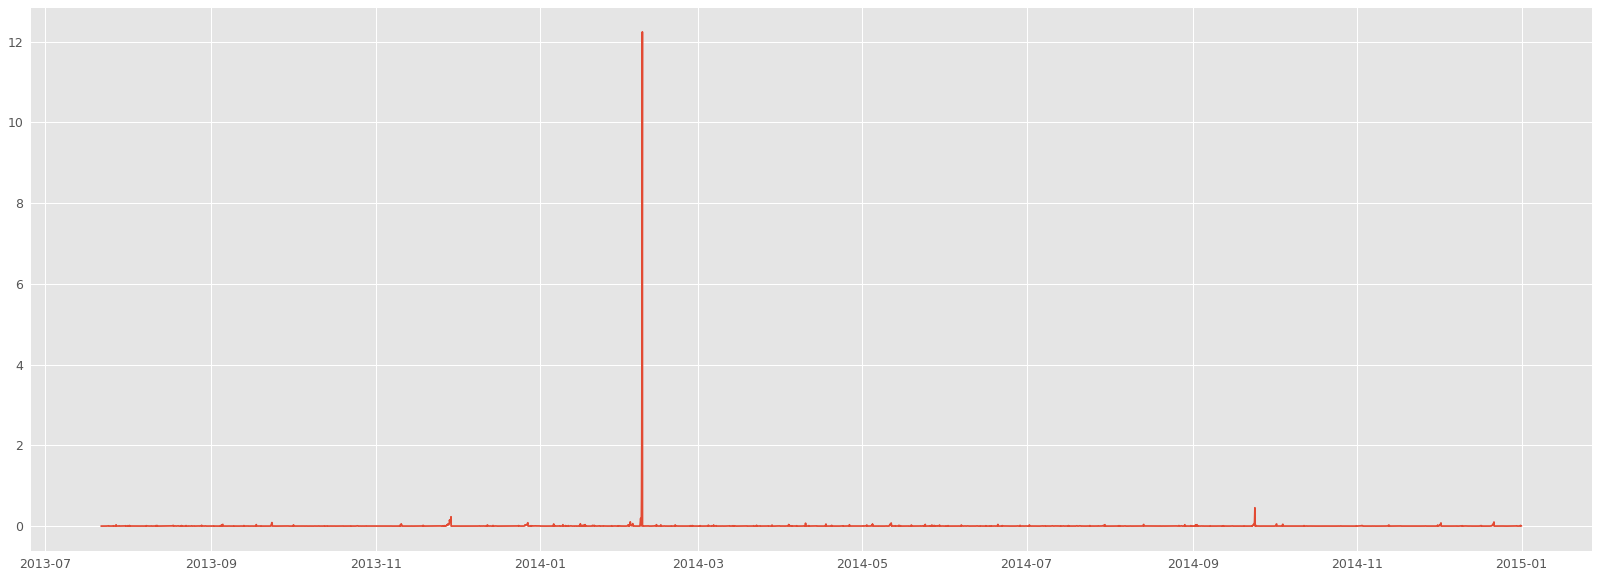

In [31]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.plot(AE.get_error_recustruction_test())

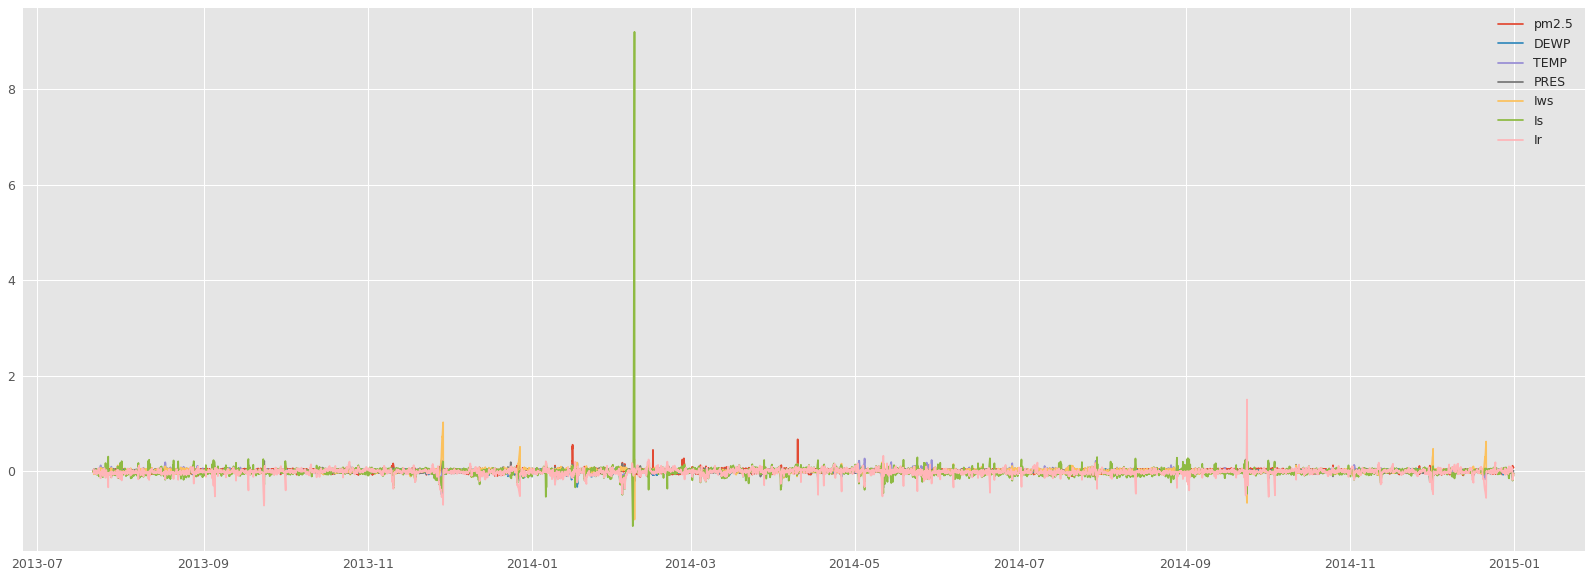

In [32]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.plot(X_test-rec_rep)
    plt.legend(X_test-rec_rep)

In [33]:
np.random.seed(42)
AE_denoising = AutoEncoder(num_features=X_train.shape[1],num_latent_node=2*X_train.shape[1], lamda = 0.00001)
AE_denoising.model_settings()
#X_train_noise = random_noise(X_train, mode='pepper')
#gaussian_noises = np.random.normal(0,1,size=X_train.shape)
X_train_noise = noisy.noisy("s&p" ,X_train)
AE_denoising.setting_train_test_DS(X_train_noise, X_test)

/home/ec2-user/SageMaker/MASL_project_2019/progetto/lib/noisy.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
/home/ec2-user/SageMaker/MASL_project_2019/progetto/lib/noisy.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


In [34]:
AE_denoising.fit(epochs=35)
rec_rep = AE_denoising.predict_test()

Epoch 1/35
29229/29229 [==============================] - 2s 60us/sample - loss: 0.5667 - mean_squared_error: 0.5666
Epoch 2/35
29229/29229 [==============================] - 1s 51us/sample - loss: 0.2446 - mean_squared_error: 0.2443
Epoch 3/35
29229/29229 [==============================] - 1s 51us/sample - loss: 0.1510 - mean_squared_error: 0.1507
Epoch 4/35
29229/29229 [==============================] - 1s 51us/sample - loss: 0.1072 - mean_squared_error: 0.1070
Epoch 5/35
29229/29229 [==============================] - 1s 51us/sample - loss: 0.0821 - mean_squared_error: 0.0818
Epoch 6/35
29229/29229 [==============================] - 1s 51us/sample - loss: 0.0648 - mean_squared_error: 0.0646
Epoch 7/35
29229/29229 [==============================] - 1s 51us/sample - loss: 0.0525 - mean_squared_error: 0.0523
Epoch 8/35
29229/29229 [==============================] - 1s 51us/sample - loss: 0.0431 - mean_squared_error: 0.0430
Epoch 9/35
29229/29229 [==============================] - 1s 51u

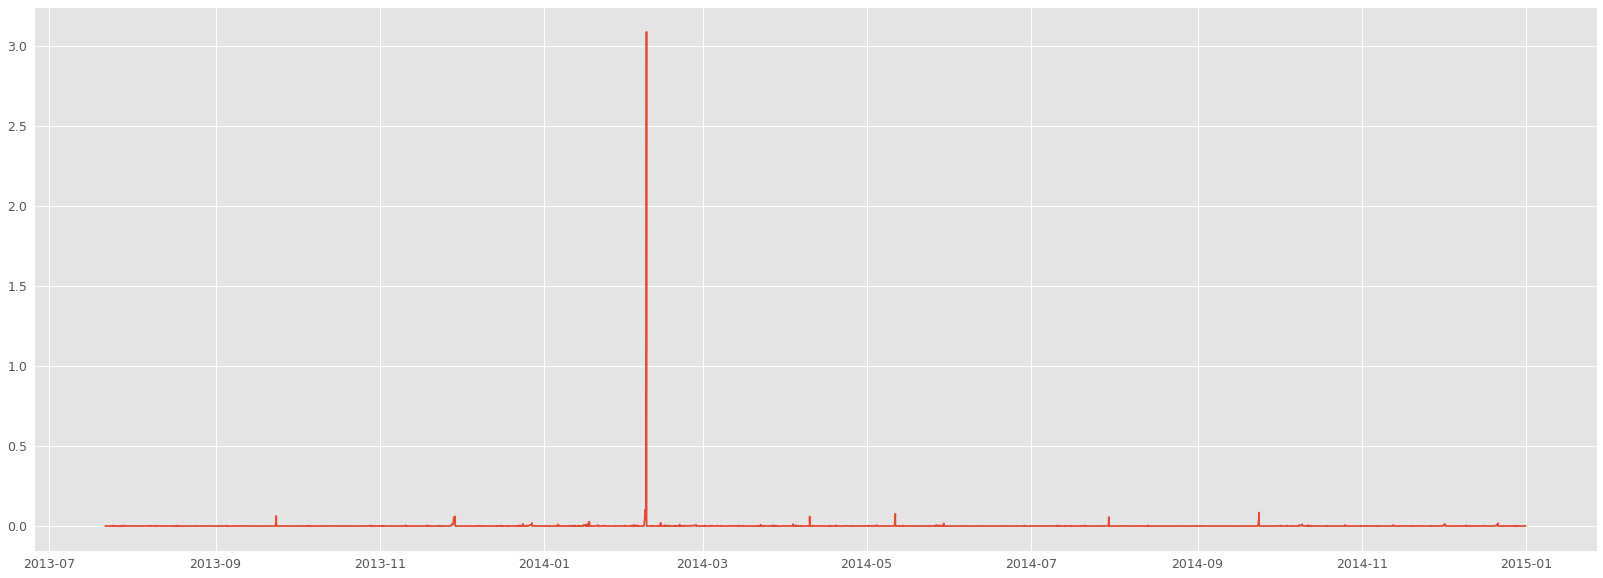

In [35]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.plot(AE_denoising.get_error_recustruction_test())

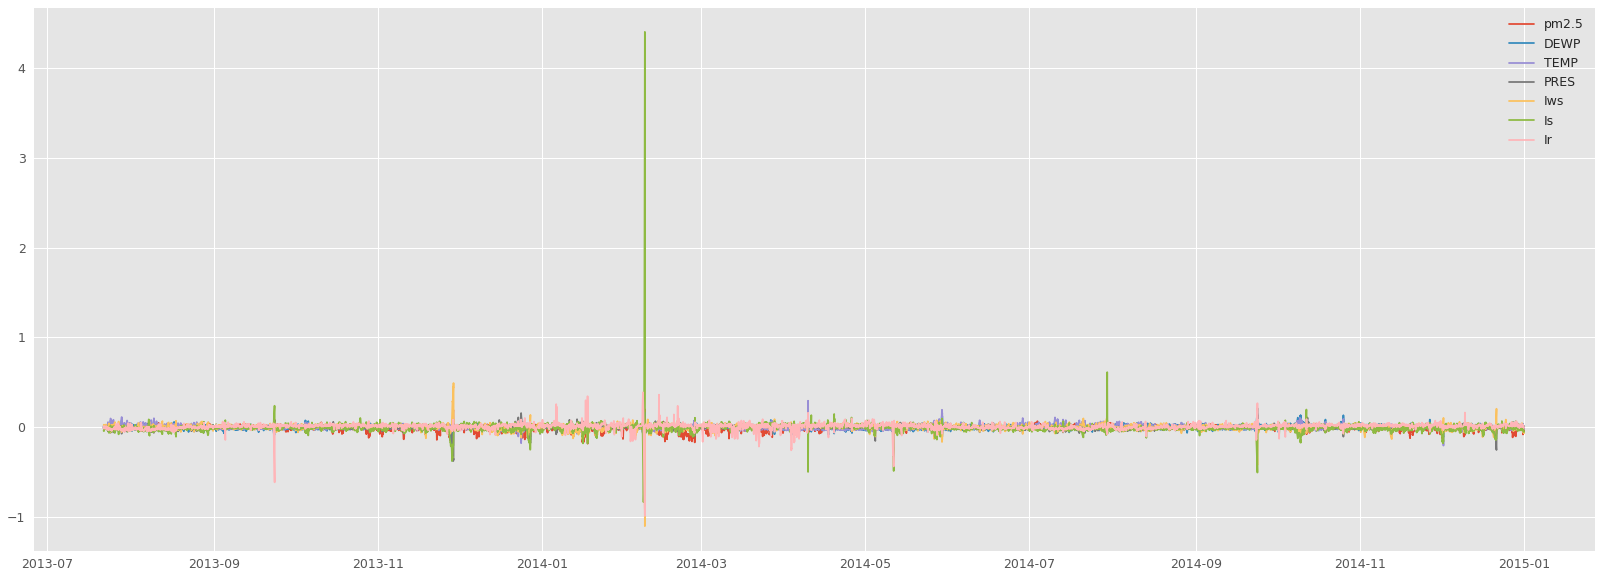

In [36]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.plot(X_test-rec_rep)
    plt.legend(X_test-rec_rep)